## Setup and imports

In [1]:
import gymnasium as gym
import pprint
from stable_baselines3 import HerReplayBuffer, SAC
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from parking_config import *

print(env.spec)
pprint.pprint(env.config)

c:\Users\adrie\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EnvSpec(id='parking-v0', entry_point='highway_env.envs:ParkingEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='parking', version=0, additional_wrappers=(), vector_entry_point=None)
{'action': {'type': 'ContinuousAction'},
 'add_walls': True,
 'centering_position': [0.5, 0.5],
 'collision_reward': -5,
 'controlled_vehicles': 1,
 'duration': 100,
 'manual_control': False,
 'observation': {'features': ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
                 'normalize': False,
                 'scales': [100, 100, 5, 5, 1, 1],
                 'type': 'KinematicsGoal'},
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 5,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_weights': [1, 0.5, 0.1, 0.1, 0.02, 0.02],
 'scaling': 7,


Action space: Box(-1.0, 1.0, (2,), float32)
Observation space: Dict('achieved_goal': Box(-inf, inf, (6,), float64), 'desired_goal': Box(-inf, inf, (6,), float64), 'observation': Box(-inf, inf, (6,), float64))


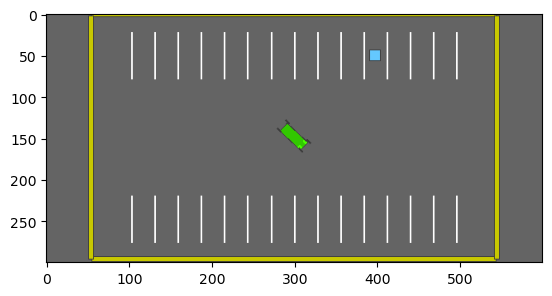

In [2]:
action_space = env.action_space
observation_space = env.observation_space

print(f"Action space: {action_space}")
print(f"Observation space: {observation_space}")

plt.imshow(env.render())
plt.show()

## Train the agent

FlattenObservation subclass created in the case that we wanted to experiment with multiple vehicles, since the observations would then have been a 2D array which needs to be flattened before it can be inputed into the SAC algorithm. It is not used in the final configuration with only one vehicle in the simulation.

In [45]:
class FlattenObservation(gym.Wrapper):
    def _init_(self, env: gym.Env):
        super()._init_(env)

    def observation(self, observation: np.ndarray) -> np.ndarray:
        return observation.flatten()

STEPS = 1e5 # 1e5
env_train = FlattenObservation(deepcopy(env))
her_kwargs = dict(n_sampled_goal=4, goal_selection_strategy='future')
agent = SAC('MultiInputPolicy', env_train, replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=her_kwargs, verbose=0,
            tensorboard_log=os.path.join("logs", f"train_hrb_sac_3x256_{STEPS}"),
            learning_rate=1e-3,
            gamma=0.95, batch_size=1024, tau=0.05,
            learning_starts=1000,  
            device="cuda")

agent.learn(total_timesteps=int(STEPS))

The following cell is used to show training results with the Tensorboad interface directly in a Jupyter notebook. 

In [4]:
%load_ext tensorboard

%tensorboard --logdir logs

## Evaluate agent

In this part, we will reuse the eval_agent utility function as in the previous environments, to gather some statistics on the performances of our trained agent. Here, we are focused both on the sum of rewards throughout the episodes but also on the outcome of the simulation (crashed, reached the goal or time out).

In [46]:
def eval_agent(agent, env, n_sim=5):
    """
    ** Solution **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    all_rewards = {i: [] for i in range(n_sim)}
    final_rewards = {i: [] for i in range(n_sim)}
    all_actions = {}
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done: 
            action, _ = agent.predict(state, deterministic=True)
            # print(action)
            # all_actions[action] = all_actions.get(action, 0) + 1
            state, reward, terminated, truncated, _ = env_copy.step(action)
            all_rewards[i].append(reward)
            reward_sum += reward
            done = terminated or truncated
        final_rewards[i] = reward
        episode_rewards[i] = reward_sum
    return episode_rewards, all_rewards, final_rewards, all_actions

# Evaluate the final policy
N_sim = 100
rewards, all_rewards, final_rewards, all_actions = eval_agent(agent, env, N_sim)
final_states = []
nb_steps = []
for i in range(N_sim):
    final_reward = final_rewards[i]
    final_state = "crashed" if final_reward < -5 else ("reached" if final_reward > - env.config['success_goal_reward'] else "timed out")
    final_states.append(final_state)
    nb_steps.append(len(all_rewards[i]))
    print(f"Episode {i + 1} : {final_state} in {len(all_rewards[i])} steps")
    # print(f"    All rewards : {all_rewards[i]}")

Episode 1 : crashed in 16 steps
Episode 2 : timed out in 500 steps
Episode 3 : crashed in 15 steps
Episode 4 : crashed in 15 steps
Episode 5 : timed out in 500 steps
Episode 6 : reached in 26 steps
Episode 7 : reached in 25 steps
Episode 8 : reached in 27 steps
Episode 9 : reached in 26 steps
Episode 10 : timed out in 500 steps
Episode 11 : timed out in 500 steps
Episode 12 : reached in 26 steps
Episode 13 : crashed in 17 steps
Episode 14 : reached in 25 steps
Episode 15 : timed out in 500 steps
Episode 16 : reached in 26 steps
Episode 17 : timed out in 500 steps
Episode 18 : timed out in 500 steps
Episode 19 : crashed in 22 steps
Episode 20 : crashed in 19 steps
Episode 21 : reached in 24 steps
Episode 22 : timed out in 500 steps
Episode 23 : crashed in 24 steps
Episode 24 : reached in 43 steps
Episode 25 : timed out in 500 steps
Episode 26 : reached in 26 steps
Episode 27 : timed out in 500 steps
Episode 28 : timed out in 500 steps
Episode 29 : reached in 24 steps
Episode 30 : reache

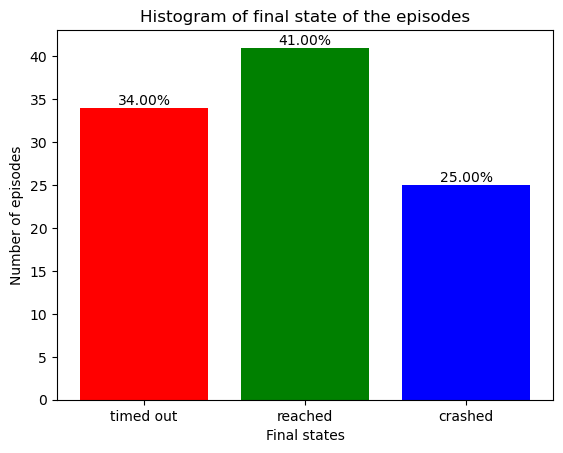

In [47]:
# Count the occurrences of each word
word_counts = {word: final_states.count(word) for word in set(final_states)}

# Extract words and their corresponding counts
words = list(word_counts.keys())
counts = list(word_counts.values())

# Calculate percentages
total_count = sum(counts)
percentages = [count / total_count * 100 for count in counts]

# Plot histogram
bars = plt.bar(words, counts, color=['red', 'green', 'blue'])  # Customize colors as needed
plt.xlabel('Final states')
plt.ylabel('Number of episodes')
plt.title('Histogram of final state of the episodes')

# Annotate bars with percentages
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.2f}%', 
             ha='center', va='bottom')
plt.savefig(f"final_states_{STEPS}.png")
plt.show()

Mean number of steps to reach the goal: 40.609756097560975 +/- 29.67044850646275


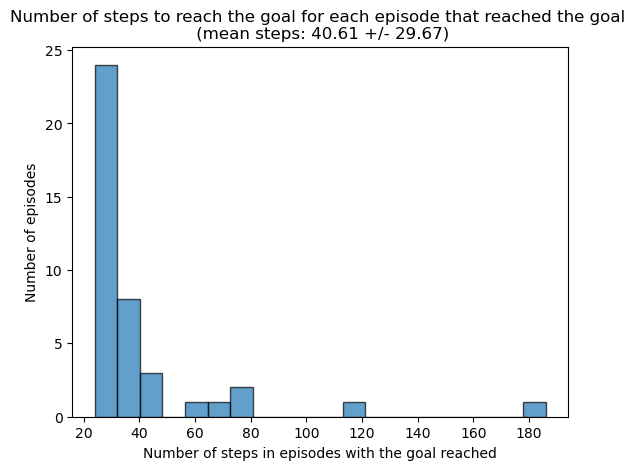

In [48]:
# get the mean and std of the nb_steps for the episodes that reached the goal
nb_steps_reached = [nb_steps[i] for i in range(N_sim) if final_states[i] == "reached"]
mean_steps = np.mean(nb_steps_reached)
std_steps = np.std(nb_steps_reached)
print(f"Mean number of steps to reach the goal: {mean_steps} +/- {std_steps}")

# bar plot of the nb_steps for the episodes that reached the goal
plt.hist(nb_steps_reached, bins=20, edgecolor='black', alpha=0.7)
plt.ylabel("Number of episodes")
plt.xlabel("Number of steps in episodes with the goal reached")
plt.title("Number of steps to reach the goal for each episode that reached the goal \n (mean steps: {:.2f} +/- {:.2f})".format(mean_steps, std_steps))
plt.savefig(f"nb_steps_reached_{STEPS}.png")
plt.show()

Mean rewards when reaching the goal: -12.81651627812794 +/- 6.255790585536521


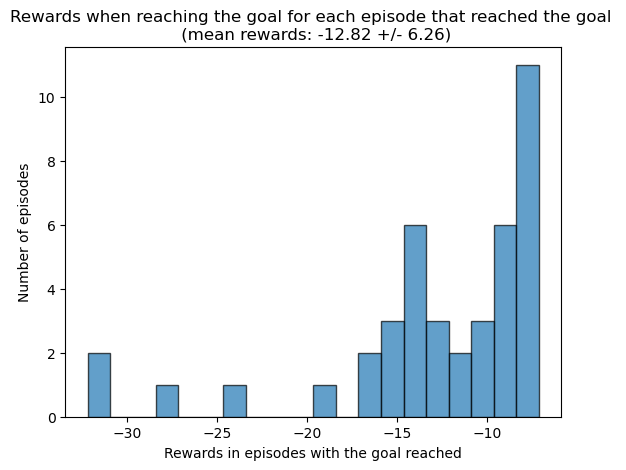

In [49]:
# same as above but for the rewards
rewards_reached = [rewards[i] for i in range(N_sim) if final_states[i] == "reached"]
mean_rewards = np.mean(rewards_reached)
std_rewards = np.std(rewards_reached)
print(f"Mean rewards when reaching the goal: {mean_rewards} +/- {std_rewards}")

plt.hist(rewards_reached, bins=20, edgecolor='black', alpha=0.7)
plt.ylabel("Number of episodes")
plt.xlabel("Rewards in episodes with the goal reached")
plt.title("Rewards when reaching the goal for each episode that reached the goal \n (mean rewards: {:.2f} +/- {:.2f})".format(mean_rewards, std_rewards))
plt.savefig(f"rewards_reached_{STEPS}.png")
plt.show()

### Additional plots

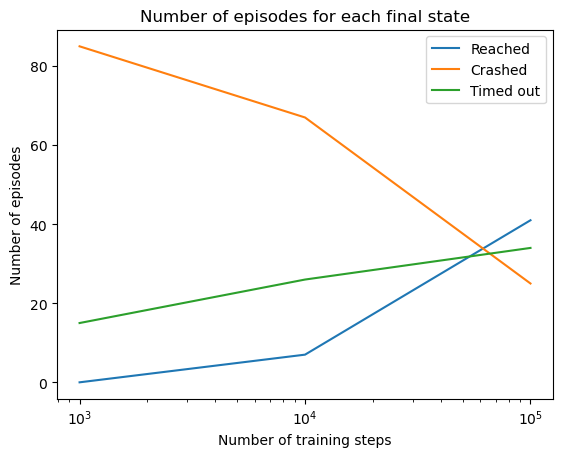

In [51]:
nb_reached = [0, 7, 41]
nb_crashed = [85, 67, 25]
nb_timed_out = [15, 26, 34]

nb_steps_mean = [np.inf, 100.14, 40.61]
rewards_mean = [-np.inf, -22.98, -12.82]

x_axis_values = [10**3, 10**4, 10**5]

plt.plot(x_axis_values, nb_reached, label="Reached")
plt.plot(x_axis_values, nb_crashed, label="Crashed")
plt.plot(x_axis_values, nb_timed_out, label="Timed out")
plt.xscale("log")
plt.xlabel("Number of training steps")
plt.ylabel("Number of episodes")
plt.title("Number of episodes for each final state")
plt.legend()
plt.savefig(f"final_states_full.png")
plt.show()

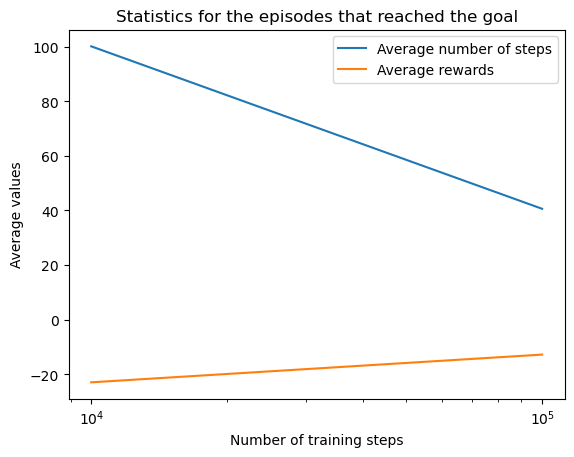

In [53]:
plt.plot(x_axis_values, nb_steps_mean, label="Average number of steps")
plt.plot(x_axis_values, rewards_mean, label="Average rewards")
plt.xscale("log")
plt.xlabel("Number of training steps")
plt.ylabel("Average values")
plt.title("Statistics for the episodes that reached the goal")
plt.legend()
plt.savefig(f"stats_full.png")
plt.show()

## Visualise episodes and save video

The two following cells are different implementations of the same objective : create a video and save

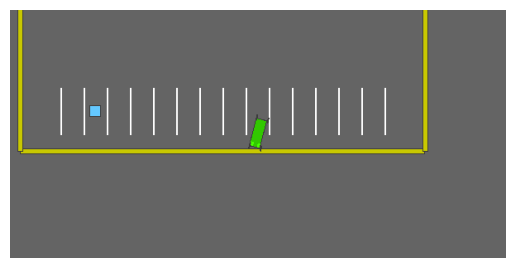

Episode length: -52.345280654528175


In [7]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, clear_output
import gymnasium as gym
import numpy as np
from copy import deepcopy

def run_one_episode_and_save(env, agent, to_display=True, save_video=True, plot_info=True, max_steps=100):
    display_env = deepcopy(env)  # Create a deep copy of the environment for isolated manipulation
    state, _ = display_env.reset()
    frames = []  # Store frames for animation
    rewards = 0
    step = 0
    state_history = []

    done = False
    while not done:
        clear_output(wait=True)
        # Render the frame and store for video creation
        frame = display_env.render()
        frames.append(frame)
        if to_display:
            plt.imshow(frame)
            plt.axis('off')  # Hide axes for clean display
            plt.show()

        # Execute the agent's policy
        action, _ = agent.predict(state, deterministic=True)  # Assuming get_action accepts state and epsilon, adjust if different
        # action = [np.array(action.squeeze(), dtype=np.float32)]
        state, reward, done, _, _ = display_env.step(action)
        rewards += reward
        step += 1
        if plot_info:
            state_history.append(state)
        if step > max_steps:
            done = True
        

    if to_display:
        print(f'Episode length: {rewards}')

    # If requested to save the video, proceed with saving
    if save_video:
        fig, ax = plt.subplots()
        img_ax = ax.imshow(frames[0])  # Show the first frame
        ax.axis('off')  # Hide axes

        def update(frame):
            img_ax.set_data(frame)  # Update the image displayed

        ani = FuncAnimation(fig, update, frames=frames, repeat=False)

        # Save the animation as MP4
        video_filename = 'parkig_simulation_modified_weights_and_succes_goal_reward.mp4'
        ani.save(video_filename, writer='ffmpeg', fps=10)

        # Optionally display the animation within the notebook
        plt.close(fig)  # Close the figure to prevent it from displaying now
        if to_display:
            video_tag = f'<video src="{video_filename}" width="100%" controls loop autoplay>'
            display(HTML(video_tag))

    if to_display:
        display_env.close()  # Properly close the environment when done

    if plot_info:
        # Plot the heatmap of the state values on average over time 
        state_history = np.array(state_history)
        print(f"State history: {state_history}")
        mean_state_history = np.sum(state_history, axis=0) / state_history.shape[0]
        presence = mean_state_history[:, :, 0]
        # speed = mean_state_history[:, :, 1]
        # lane = mean_state_history[:, :, 2]
        plt.figure(figsize=(15, 5))
        plt.imshow(presence, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.title('Heatmap of presence')
        plt.show()

# simulate the trained agent and save the video
run_one_episode_and_save(env, agent, to_display=True, save_video=True, plot_info=False, max_steps=200)

The above video show an episode where the agent does not manage to reach the goal. For a successful example, see parking_simulation_with_modofied_config.mp4